# DEF CON 27 AI Village
## Fighting Malware with Deep Learning
## Multilayer Perceptron and Static Analysis Data (PE Section Headers and PE Imports)
### Angelo Oliveira @ang3loliveira

#### Datasets available at:
https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-pe-section-headers<br>
https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-top1000-pe-imports

In [1]:
import numpy as np
np.random.seed(137)

import time
from collections import Counter
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [2]:
df_1 = pd.read_csv('pe_section_headers.csv')
df_1.head()

,hash,size_of_data,virtual_address,entropy,virtual_size,malware
0,071e8c3f8922e186e57548cd4c703a5d,443392,4096,6.529624,442984,1
1,33f8e6d08a6aae939f25a8e0d63dd523,331264,4096,6.604314,330784,1
2,b68abd064e975e1c6d5f25e748663076,74240,4096,6.046789,73819,1
3,72049be7bd30ea61297ea624ae198067,219648,4096,6.497018,219524,1
4,c9b3700a77facf29172f32df6bc77f48,262144,4096,6.638142,261943,1


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43293 entries, 0 to 43292
Data columns (total 6 columns):
hash               43293 non-null object
size_of_data       43293 non-null int64
virtual_address    43293 non-null int64
entropy            43293 non-null float64
virtual_size       43293 non-null int64
malware            43293 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.0+ MB


In [4]:
# Static analysis data: No duplicate hashes, since the data is the same always
df_1.drop_duplicates(['hash'], inplace = True)

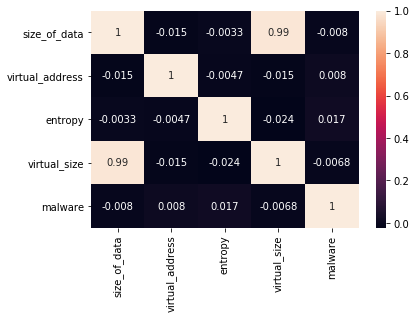

In [5]:
sns.heatmap(df_1.corr(), annot = True)

In [6]:
df_1.drop(['size_of_data'], axis = 1, inplace = True)

In [7]:
# Top-1000 imported functions
df_2 = pd.read_csv('top_1000_pe_imports.csv')
df_2.head()

,hash,GetProcAddress,ExitProcess,WriteFile,GetLastError,CloseHandle,FreeLibrary,Sleep,GetStdHandle,MultiByteToWideChar,...,bind,RegEnumKeyExA,WinHttpOpen,_controlfp,WinExec,GetSecurityDescriptorDacl,FindFirstFreeAce,GetTimeFormatW,LookupAccountSidW,malware
0,071e8c3f8922e186e57548cd4c703a5d,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,33f8e6d08a6aae939f25a8e0d63dd523,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,b68abd064e975e1c6d5f25e748663076,1,1,1,1,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
3,72049be7bd30ea61297ea624ae198067,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,c9b3700a77facf29172f32df6bc77f48,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [8]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47580 entries, 0 to 47579
Columns: 1002 entries, hash to malware
dtypes: int64(1001), object(1)
memory usage: 363.7+ MB


In [9]:
df_2.drop_duplicates(['hash'], inplace = True)

In [10]:
# Merging PE Sections Header with PE Imports
df = pd.merge(df_1, df_2, on = 'hash')
del df_1, df_2
df.head()

,hash,virtual_address,entropy,virtual_size,malware_x,GetProcAddress,ExitProcess,WriteFile,GetLastError,CloseHandle,...,bind,RegEnumKeyExA,WinHttpOpen,_controlfp,WinExec,GetSecurityDescriptorDacl,FindFirstFreeAce,GetTimeFormatW,LookupAccountSidW,malware_y
0,071e8c3f8922e186e57548cd4c703a5d,4096,6.529624,442984,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,33f8e6d08a6aae939f25a8e0d63dd523,4096,6.604314,330784,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,b68abd064e975e1c6d5f25e748663076,4096,6.046789,73819,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,1
3,72049be7bd30ea61297ea624ae198067,4096,6.497018,219524,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,c9b3700a77facf29172f32df6bc77f48,4096,6.638142,261943,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [11]:
df.drop(['hash', 'malware_x'], axis = 1, inplace = True)
df.rename(columns = { "malware_y" : "malware" }, inplace = True)
df.head()

,virtual_address,entropy,virtual_size,GetProcAddress,ExitProcess,WriteFile,GetLastError,CloseHandle,FreeLibrary,Sleep,...,bind,RegEnumKeyExA,WinHttpOpen,_controlfp,WinExec,GetSecurityDescriptorDacl,FindFirstFreeAce,GetTimeFormatW,LookupAccountSidW,malware
0,4096,6.529624,442984,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,4096,6.604314,330784,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,4096,6.046789,73819,1,1,1,1,1,0,1,...,0,1,0,0,0,0,0,0,0,1
3,4096,6.497018,219524,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4096,6.638142,261943,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43144 entries, 0 to 43143
Columns: 1004 entries, virtual_address to malware
dtypes: float64(1), int64(1003)
memory usage: 330.8 MB


In [13]:
X = df.values[:, 0:3].astype('float')
X = np.concatenate((X, df.values[:, 3:1003].astype('uint8')), axis = 1)
y = df.values[:, 1003].astype('uint8')
print(X.shape)
print(y.shape)

(43144, 1003)
(43144,)


In [14]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [15]:
check_imbalance(y)

[(0, 1697), (1, 41447)]
24.42368886269888


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

del X
del y

In [17]:
check_imbalance(y_train)
check_imbalance(y_test)

[(0, 1174), (1, 29026)]
24.724020442930154
[(0, 523), (1, 12421)]
23.749521988527725


In [18]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[:, 0:3])
X_train_std = np.concatenate((X_train_std, X_train[:, 3:1003]), axis = 1)

In [19]:
pd.DataFrame(X_train_std).head()

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,1001,1002
0,-0.039129,-1.657683,-0.444274,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.039129,0.216449,1.950755,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.039129,0.279173,-0.315642,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.039129,-0.040904,1.490111,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.039129,0.005040,-0.424652,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pd.DataFrame(X_train_std).describe()

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,1001,1002
count,3.020000e+04,3.020000e+04,3.020000e+04,30200.000000,30200.000000,30200.00000,30200.000000,30200.000000,30200.000000,30200.000000,...,30200.000000,30200.000000,30200.000000,30200.00000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,-4.705581e-18,5.564487e-13,-5.176139e-17,0.863742,0.841391,0.83298,0.858278,0.844536,0.750596,0.730662,...,0.026821,0.027649,0.027649,0.00394,0.026258,0.026457,0.026656,0.026060,0.026291,0.026192
std,1.000017e+00,1.000017e+00,1.000017e+00,0.343068,0.365317,0.37300,0.348770,0.362352,0.432675,0.443623,...,0.161563,0.163968,0.163968,0.06265,0.159905,0.160492,0.161078,0.159315,0.160003,0.159709
min,-3.912894e-02,-7.076839e+00,-5.296303e-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.912894e-02,4.276434e-02,-4.761753e-01,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.912894e-02,1.872247e-01,-3.156422e-01,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-3.912894e-02,2.791732e-01,-1.677422e-01,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.485929e+02,1.788269e+00,4.273767e+01,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# SMOTE doesn't deal with categorical features
# SMOTE-NC (Nominal and Continuous) taking too much time

oversampler = RandomOverSampler()

X_res, y_res = oversampler.fit_resample(X_train_std, y_train)

check_imbalance(y_res)

del X_train_std

[(0, 29026), (1, 29026)]
1.0


## Visualization

In [22]:
def visualize(X, y, points, n_features):
    points = np.arange(points)
    np.random.shuffle(points)
    color = ['red' if l == 1 else 'green' for l in y[points]]
    for i in range(n_features):
        for j in range(n_features):
            if j > i:
                plt.scatter(X[points, i], X[points, j], color = color)
                plt.pause(0.1)
    return

In [23]:
def tsne(X):
    return TSNE().fit_transform(X)

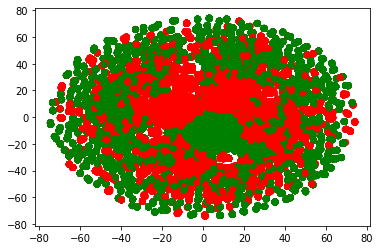

In [24]:
visualize(tsne(X_res[:, 0:3]), y_res, X_res.shape[0], 2)

del X_res
del y_res

## Enter Deep Learning

In [24]:
def select_model(model, model_arch, dropout_rate):
    if model_arch == 1:
        model.add(Dropout(rate = dropout_rate))
        model.add(BatchNormalization())
    elif model_arch == 2:
        model.add(BatchNormalization())
        model.add(Dropout(rate = dropout_rate))
    return

def create_model(model_arch = 1, neurons = 128, dropout_rate = 0.1):
    model = Sequential()
    model.add(Dense(neurons, input_shape = (1003, ), activation = 'relu'))
    select_model(model, model_arch, dropout_rate)
    model.add(Dense(neurons, activation = 'relu'))
    select_model(model, model_arch, dropout_rate)
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 128)               128512    
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 128)               512       
_________________________________________________________________
dense_176 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_118 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 128)               512       
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 129       
Total para

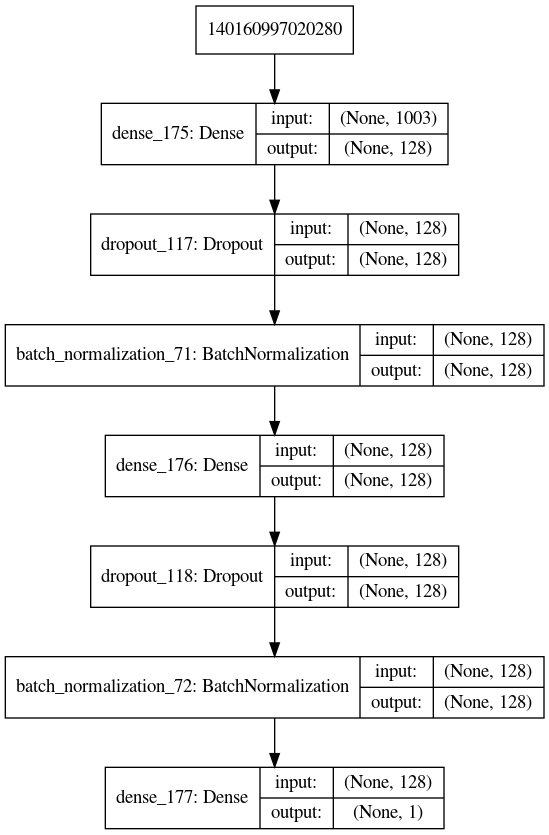

In [63]:
model = create_model()
model.summary()

plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)
del model
Image("model_plot.png")

## Model Selection

In [64]:
# Wrapper for Keras model to be used by the Pipeline
keras_classifier = KerasClassifier(
    build_fn = create_model,
    model_arch = 1,
    neurons = 128,
    dropout_rate = 0.1,
    batch_size = 32,
    epochs = 20,
    verbose = 1
)

# Tranformer for the numeric columns
numeric_transformer = Pipeline([
    ('ss', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [(
        'nt',
        numeric_transformer,
        [0, 1, 2]
    )],
    remainder = "passthrough"
)       

# Imbalanced Learn Pipeline
pipeline = Pipeline([
    ('pp', preprocessor),
    ('ros', RandomOverSampler()),
    ('kc', keras_classifier)
])

# Hyperparameters
model_arch = [1, 2]
neurons = [128, 256, 512]
dropout_rate = [0.1, 0.4, 0.6]

# Grid search using 3-fold cross-validation and score function Balanced Accuracy
# Balanced Accuracy = (TPR + TNR) / 2 = AUC (Binary Classification)
param_grid = dict(
    kc__model_arch = model_arch,
    kc__neurons = neurons,
    kc__dropout_rate = dropout_rate
)

grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'balanced_accuracy',
    n_jobs = 1
)

In [65]:
t0 = time.time()
grid.fit(X_train, y_train)
print('Training / CV time: %is' % (time.time() - t0))

/home/angelo/anaconda3/envs/deeplearning_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/20
38654/38654 [==============================] - 11s 285us/step - loss: 0.1461 - acc: 0.9498
Epoch 2/20
38654/38654 [==============================] - 6s 160us/step - loss: 0.1007 - acc: 0.9666
Epoch 3/20
38654/38654 [==============================] - 6s 165us/step - loss: 0.0877 - acc: 0.9702
Epoch 4/20
38654/38654 [==============================] - 7s 168us/step - loss: 0.0834 - acc: 0.9723
Epoch 5/20
38654/38654 [==============================] - 6s 146us/step - loss: 0.0784 - acc: 0.9735
Epoch 6/20
38654/38654 [==============================] - 6s 150us/step - loss: 0.0735 - acc: 0.9751
Epoch 7/20
38654/38654 [==============================] - 6s 151us/step - loss: 0.0725 - acc: 0.9751
Epoch 8/20
38654/38654 [==============================] - 6s 153us/step - loss: 0.0694 - acc: 0.9759
Epoch 9/20
38654/38654 [==============================] - 6s 160us/step - loss: 0.0684 - acc: 0.9758
Epoch 10/20
38654/38654 [==============================] - 7s 174us/step - loss: 0.0663 - 

38720/38720 [==============================] - 6s 153us/step - loss: 0.0639 - acc: 0.9796
Epoch 18/20
38720/38720 [==============================] - 6s 153us/step - loss: 0.0660 - acc: 0.9790
Epoch 19/20
38720/38720 [==============================] - 6s 151us/step - loss: 0.0631 - acc: 0.9787
Epoch 20/20
10067/10067 [==============================] - 3s 289us/step
Epoch 1/20
38730/38730 [==============================] - 11s 294us/step - loss: 0.1503 - acc: 0.9518
Epoch 2/20
38730/38730 [==============================] - 6s 152us/step - loss: 0.1027 - acc: 0.9673
Epoch 3/20
38730/38730 [==============================] - 6s 155us/step - loss: 0.0940 - acc: 0.9696
Epoch 4/20
38730/38730 [==============================] - 6s 153us/step - loss: 0.0871 - acc: 0.9716
Epoch 5/20
38730/38730 [==============================] - 6s 153us/step - loss: 0.0846 - acc: 0.9730
Epoch 6/20
38730/38730 [==============================] - 6s 154us/step - loss: 0.0805 - acc: 0.9744
Epoch 7/20
38730/38730 [==

38654/38654 [==============================] - 7s 189us/step - loss: 0.0588 - acc: 0.9791
Epoch 14/20
38654/38654 [==============================] - 7s 189us/step - loss: 0.0594 - acc: 0.9790
Epoch 15/20
38654/38654 [==============================] - 7s 191us/step - loss: 0.0590 - acc: 0.9791
Epoch 16/20
38654/38654 [==============================] - 7s 189us/step - loss: 0.0571 - acc: 0.9803
Epoch 17/20
38654/38654 [==============================] - 7s 191us/step - loss: 0.0588 - acc: 0.9795
Epoch 18/20
38654/38654 [==============================] - 7s 189us/step - loss: 0.0582 - acc: 0.9797
Epoch 19/20
38654/38654 [==============================] - 7s 191us/step - loss: 0.0562 - acc: 0.9804
Epoch 20/20
10067/10067 [==============================] - 4s 350us/step
Epoch 1/20
38720/38720 [==============================] - 14s 360us/step - loss: 0.1428 - acc: 0.9554
Epoch 2/20
38720/38720 [==============================] - 7s 193us/step - loss: 0.0985 - acc: 0.9699
Epoch 3/20
38720/38720

38730/38730 [==============================] - 8s 213us/step - loss: 0.0962 - acc: 0.9694
Epoch 10/20
38730/38730 [==============================] - 8s 213us/step - loss: 0.0939 - acc: 0.9703
Epoch 11/20
38730/38730 [==============================] - 8s 213us/step - loss: 0.0901 - acc: 0.9711
Epoch 12/20
38730/38730 [==============================] - 8s 213us/step - loss: 0.0923 - acc: 0.9710
Epoch 13/20
38730/38730 [==============================] - 8s 213us/step - loss: 0.0916 - acc: 0.9719
Epoch 14/20
38730/38730 [==============================] - 8s 212us/step - loss: 0.0887 - acc: 0.9720
Epoch 15/20
38730/38730 [==============================] - 8s 211us/step - loss: 0.0870 - acc: 0.9725
Epoch 16/20
38730/38730 [==============================] - 8s 212us/step - loss: 0.0860 - acc: 0.9722
Epoch 17/20
38730/38730 [==============================] - 8s 213us/step - loss: 0.0826 - acc: 0.9743
Epoch 18/20
38730/38730 [==============================] - 8s 211us/step - loss: 0.0790 - acc:

38720/38720 [==============================] - 9s 233us/step - loss: 0.1020 - acc: 0.9674
Epoch 6/20
38720/38720 [==============================] - 9s 234us/step - loss: 0.0988 - acc: 0.9684
Epoch 7/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0906 - acc: 0.9706
Epoch 8/20
38720/38720 [==============================] - 9s 234us/step - loss: 0.0890 - acc: 0.9704
Epoch 9/20
38720/38720 [==============================] - 9s 232us/step - loss: 0.0877 - acc: 0.9720
Epoch 10/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0894 - acc: 0.9714
Epoch 11/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0815 - acc: 0.9730
Epoch 12/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0821 - acc: 0.9732
Epoch 13/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0818 - acc: 0.9740
Epoch 14/20
38720/38720 [==============================] - 9s 233us/step - loss: 0.0779 - acc: 0.9

10066/10066 [==============================] - 5s 537us/step
Epoch 1/20
38654/38654 [==============================] - 20s 515us/step - loss: 0.2329 - acc: 0.9142
Epoch 2/20
38654/38654 [==============================] - 10s 252us/step - loss: 0.1644 - acc: 0.9430
Epoch 3/20
38654/38654 [==============================] - 10s 251us/step - loss: 0.1430 - acc: 0.9515
Epoch 4/20
38654/38654 [==============================] - 10s 251us/step - loss: 0.1356 - acc: 0.9545
Epoch 5/20
38654/38654 [==============================] - 10s 251us/step - loss: 0.1285 - acc: 0.9559
Epoch 6/20
38654/38654 [==============================] - 10s 268us/step - loss: 0.1264 - acc: 0.9567
Epoch 7/20
38654/38654 [==============================] - 10s 268us/step - loss: 0.1193 - acc: 0.9584
Epoch 8/20
38654/38654 [==============================] - 10s 259us/step - loss: 0.1151 - acc: 0.9614
Epoch 9/20
38654/38654 [==============================] - 10s 259us/step - loss: 0.1164 - acc: 0.9613
Epoch 10/20
38654/386

38720/38720 [==============================] - 10s 266us/step - loss: 0.1045 - acc: 0.9667
Epoch 16/20
38720/38720 [==============================] - 10s 266us/step - loss: 0.1026 - acc: 0.9679
Epoch 17/20
38720/38720 [==============================] - 10s 265us/step - loss: 0.0982 - acc: 0.9693
Epoch 18/20
38720/38720 [==============================] - 10s 266us/step - loss: 0.0988 - acc: 0.9692
Epoch 19/20
38720/38720 [==============================] - 10s 266us/step - loss: 0.0957 - acc: 0.9702
Epoch 20/20
10067/10067 [==============================] - 6s 618us/step
Epoch 1/20
38730/38730 [==============================] - 22s 560us/step - loss: 0.2474 - acc: 0.9079
Epoch 2/20
38730/38730 [==============================] - 10s 269us/step - loss: 0.1571 - acc: 0.9487
Epoch 3/20
38730/38730 [==============================] - 10s 268us/step - loss: 0.1468 - acc: 0.9529
Epoch 4/20
38730/38730 [==============================] - 10s 268us/step - loss: 0.1358 - acc: 0.9556
Epoch 5/20
38730

58052/58052 [==============================] - 16s 281us/step - loss: 0.1274 - acc: 0.9598
Epoch 10/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1229 - acc: 0.9618
Epoch 11/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1207 - acc: 0.9622
Epoch 12/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1198 - acc: 0.9631
Epoch 13/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1176 - acc: 0.9631
Epoch 14/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1163 - acc: 0.9642
Epoch 15/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1155 - acc: 0.9640
Epoch 16/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1126 - acc: 0.9652
Epoch 17/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1095 - acc: 0.9656
Epoch 18/20
58052/58052 [==============================] - 16s 281us/step - loss: 0.1

In [66]:
def grid_results(model):
    print("Best: %.4f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))

In [67]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y, pred))
    print('Accuracy: %.4f' % (accuracy_score(y, pred)))    
    print('Precision: %.4f' % (precision_score(y, pred)))    
    print('Recall: %.4f' % (recall_score(y, pred)))
    print('F1-Score: %.4f' % (f1_score(y, pred)))    
    print('Balanced Accuracy (ROC AUC): %.4f' % (balanced_accuracy_score(y, pred)))
    return

In [68]:
# Highest dropout rate, Dropout then Batchnorm, lowest number of neurons
grid_results(grid)

Best: 0.9377 using {'kc__dropout_rate': 0.6, 'kc__model_arch': 1, 'kc__neurons': 128}
0.9216 (0.0034) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 128}
0.9182 (0.0062) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 256}
0.9179 (0.0127) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 512}
0.9161 (0.0110) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 128}
0.9088 (0.0131) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 256}
0.9135 (0.0076) with: {'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 512}
0.9329 (0.0048) with: {'kc__dropout_rate': 0.4, 'kc__model_arch': 1, 'kc__neurons': 128}
0.9253 (0.0045) with: {'kc__dropout_rate': 0.4, 'kc__model_arch': 1, 'kc__neurons': 256}
0.9258 (0.0027) with: {'kc__dropout_rate': 0.4, 'kc__model_arch': 1, 'kc__neurons': 512}
0.9285 (0.0022) with: {'kc__dropout_rate': 0.4, 'kc__model_arch': 2, 'kc__neurons': 128}
0.9225 (0.0063) with: {'

## Evaluation

In [69]:
# Benchmark
model_evaluate(y_test, np.ones(y_test.shape))

Confusion matrix
[TN FP]
[FN TP]
[[    0   523]
 [    0 12421]]
Accuracy: 0.9596
Precision: 0.9596
Recall: 1.0000
F1-Score: 0.9794
Balanced Accuracy (ROC AUC): 0.5000


In [70]:
model_evaluate(y_test, grid.predict(X_test))

12944/12944 [==============================] - 7s 572us/step
Confusion matrix
[TN FP]
[FN TP]
[[  496    27]
 [  670 11751]]
Accuracy: 0.9462
Precision: 0.9977
Recall: 0.9461
F1-Score: 0.9712
Balanced Accuracy (ROC AUC): 0.9472
